In [157]:
import raw_source
import math
from tqdm import tqdm,trange
class Dataset:
    def __init__(self,text,labels,masks):
        self.text = torch.tensor(text)
        self.labels = torch.tensor(labels)
        self.masks = torch.from_numpy(masks)
    def __getitem__(self, index):
        return self.text[index],self.labels[index],self.masks[index]
    def __len__(self):
        return len(self.text)

In [158]:
train_text,train_labels,train_masks,dev_text,dev_labels,dev_masks,test_text,test_labels,test_masks,vocab_size,train_contents,dev_contents,test_contents = raw_source.main()

180000it [00:00, 344731.02it/s]
10000it [00:00, 589949.36it/s]
10000it [00:00, 526327.52it/s]


In [160]:
print('文本：',train_contents[1])
print('ont hot编码:',train_text[1])
print('文本分类label:',train_labels[1])
print('mask:',train_masks[1])
print('句子长度:',len(train_text[1]))

文本： 两天价网站背后重重迷雾：做个网站究竟要多少钱
ont hot编码: [135, 80, 33, 54, 505, 1032, 70, 95, 95, 681, 2288, 4, 486, 179, 54, 505, 626, 1156, 180, 115, 421, 561, 4761, 4761, 4761, 4761, 4761, 4761, 4761, 4761, 4761, 4761, 4761, 4761, 4761, 4761, 4761, 4761]
文本分类label: 4
mask: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
句子长度: 38


In [161]:
import torch
import numpy as np
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
train_data = Dataset(train_text, train_labels,train_masks)
train_dataloader = DataLoader(train_data,batch_size=32,shuffle=True)

In [162]:
dev_data = Dataset(dev_text, dev_labels,dev_masks)
dev_dataloader = DataLoader(dev_data,batch_size=32,shuffle=True)

In [145]:
class Config:
    def __init__(self,vocab_size):
        self.vocab_size = vocab_size
        
        #注意力头数
        self.num_attention_heads = 8 
        #字编码维度
        self.embedding_size = 240
        #每个头多大:30
        self.attention_head_size = int(self.embedding_size / self.num_attention_heads)
        
        self.all_head_size = self.num_attention_heads * self.attention_head_size
        
        self.attention_probs_dropout_prob = 0.1
        
        self.class_nums = 10
        
        self.batch_size = 32
        
        
config = Config(vocab_size)

In [218]:
import torch.nn as nn
import numpy as np
class SelfAttention(nn.Module):
    def __init__(self,config):
        super(SelfAttention, self).__init__()

        self.embedding = nn.Embedding(config.vocab_size,240)
        self.config = config
        self.query = nn.Linear(config.embedding_size, config.all_head_size)#240 * 240
        self.key = nn.Linear(config.embedding_size, config.all_head_size)#240 * 240
        self.value = nn.Linear(config.embedding_size, config.all_head_size)#240 * 240
        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)
        self.fc = nn.Linear(config.embedding_size,config.class_nums)
        
    def forward(self,text,mask):
        #text : batch,38; mask: batch,38
        text_embedding = self.embedding(text) # batch,38,240

        Q = self.query(text_embedding) # batch,38,240
        K = self.key(text_embedding) # batch,38,240
        V = self.value(text_embedding) # batch,38,240
        
        # batch seq_len 240 -> batch 8 seq_len 30
        new_shape = Q.size()[:-1] + (self.config.num_attention_heads , self.config.attention_head_size)
        Q = Q.view(*new_shape).permute(0,2,1,3) # batch 8 38 30
        K = K.view(*new_shape).permute(0,2,1,3) # batch 8 38 30
        V = V.view(*new_shape).permute(0,2,1,3) # batch 8 38 30
        # (QK^T)/sqrt(d)
        attention_scores = torch.matmul(Q,K.transpose(-1,-2))# batch 8 38 30 * batch 8 30 38 = batch 8 38 38
        attention_scores = attention_scores / math.sqrt(self.config.attention_head_size)
        
        
        # 变换mask
        extended_img_mask = mask.unsqueeze(1).unsqueeze(2) # batch 1 1 38 思考广播机制
        extended_img_mask = (1.0 - extended_img_mask) * -10000.0 # batch 1 1 38
        attention_scores = attention_scores + extended_img_mask
        
        #softmax((QK^T)/sqrt(d))
        attention_probs = nn.Softmax(dim=-1)(attention_scores)# batch 8 38
        attention_probs = self.dropout(attention_probs).to(torch.float) 
        
        res = torch.matmul(attention_probs,V)# batch 8 38 30
        
        res = res.permute(0,2,1,3)#.contiguous() #batch 38 8 30
        ori_shape = res.size()[:-2] + (self.config.all_head_size,)
        res = res.view(*ori_shape) # batch 38 240
        
        res = torch.mean(res,axis = 1) # batch 240 
        pred = self.fc(res)
        
        return pred , attention_probs
        

In [175]:
import torch
a = torch.rand(5,4,3)
b = torch.rand(10,1,3,2)
torch.matmul(a,b).shape

torch.Size([10, 5, 4, 2])

In [232]:
import torch.nn as nn
import numpy as np
class SelfAttention_Print(nn.Module):
    def __init__(self,config):
        super(SelfAttention_Print, self).__init__()
        self.embedding = nn.Embedding(config.vocab_size,240)
        self.config = config
        self.query = nn.Linear(config.embedding_size, config.all_head_size)#240 * 240
        self.key = nn.Linear(config.embedding_size, config.all_head_size)#240 * 240
        self.value = nn.Linear(config.embedding_size, config.all_head_size)#240 * 240
        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)
        self.fc = nn.Linear(config.embedding_size,config.class_nums)
        
    def forward(self,text,mask):
        #text : batch,38; mask: batch,38
        text_embedding = self.embedding(text) # batch,38,240
        print('text_embedding:',text_embedding.shape)
        
        Q = self.query(text_embedding) # batch,38,240
        K = self.key(text_embedding) # batch,38,240
        V = self.value(text_embedding) # batch,38,240
        print('Q:',Q.shape)
        print('K:',K.shape)
        print('V:',V.shape)
        
        # batch seq_len 240 -> batch 8 seq_len 30
        new_shape = Q.size()[:-1] + (self.config.num_attention_heads , self.config.attention_head_size)
        Q = Q.view(*new_shape).permute(0,2,1,3) # batch 8 38 30
        K = K.view(*new_shape).permute(0,2,1,3) # batch 8 38 30
        V = V.view(*new_shape).permute(0,2,1,3) # batch 8 38 30
        print('Q:',Q.shape)
        print('K:',K.shape)
        print('V:',V.shape)
        
        # (QK^T)/sqrt(d)
        attention_scores = torch.matmul(Q,K.transpose(-1,-2))# batch 8 38 30 * batch 8 30 38 = batch 8 38 38
        attention_scores = attention_scores / math.sqrt(self.config.attention_head_size)
        print('attention_scores:',attention_scores.shape)
        
        # 变换mask
        extended_img_mask = mask.unsqueeze(1).unsqueeze(2) # batch 1 1 38 思考广播机制
        extended_img_mask = (1 - extended_img_mask) * -10000 # batch 1 1 38
        print('extended_img_mask:',extended_img_mask.dtype)
        print('attention_scores:',attention_scores.dtype)
        print('extended_img_mask:',extended_img_mask.shape)
        attention_scores = attention_scores + extended_img_mask
        attention_scores = attention_scores.to(torch.float) 
        print('attention_scores:',attention_scores.shape)
        #softmax((QK^T)/sqrt(d))
        attention_probs = nn.Softmax(dim=-1)(attention_scores)# batch 8 38 38
        print('after softmax attention_scores:',attention_scores.shape)
        attention_probs = self.dropout(attention_probs)
        
        res = torch.matmul(attention_probs,V)# batch 8 38 30
        print('res:',res.shape)
        print(res.is_contiguous()) #True
        res = res.permute(0,2,1,3)#.contiguous() #batch 38 8 30
        print(res.is_contiguous()) #False
        ori_shape = res.size()[:-2] + (self.config.all_head_size,)
        res = res.reshape(*ori_shape) # batch 38 240 view必须要一个连续存储的tensor 必须is_contiguous() 是True
        print('res:',res.shape)
        res = torch.mean(res,axis = 1)#batch 240
        print('res:',res.shape)
        pred = self.fc(res)
        print('pred:',pred.shape)#batch 10
        return pred , attention_probs

In [233]:
# view reshape 原变量 : 加不加都会改，相当于都没有深拷贝 一般是a = a.reshape() reshape 是 先continuous 再view两个操作（回去看看） 
# permute transpose 如果加了.contiguous() 就能深拷贝了
import copy
a = torch.rand((2,3))
b = a.contiguous()

print(id(a.data))
id(b.data)
print(a)
b[0][0] = 1
print(a)


2424868206912
tensor([[0.3695, 0.1577, 0.3516],
        [0.2821, 0.0894, 0.9786]])
tensor([[1.0000, 0.1577, 0.3516],
        [0.2821, 0.0894, 0.9786]])


In [234]:
model = SelfAttention_Print(config)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0)
criterion = torch.nn.CrossEntropyLoss()

In [235]:
model = model.train()
for i,batch in enumerate(train_dataloader):
    if i == 0:
        train_text,train_labels,train_masks = batch
        pred,attention_probs = model(train_text,train_masks)
        loss = criterion(pred,train_labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    else:
        break

text_embedding: torch.Size([32, 38, 240])
Q: torch.Size([32, 38, 240])
K: torch.Size([32, 38, 240])
V: torch.Size([32, 38, 240])
Q: torch.Size([32, 8, 38, 30])
K: torch.Size([32, 8, 38, 30])
V: torch.Size([32, 8, 38, 30])
attention_scores: torch.Size([32, 8, 38, 38])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 38])
attention_scores: torch.Size([32, 8, 38, 38])
after softmax attention_scores: torch.Size([32, 8, 38, 38])
res: torch.Size([32, 8, 38, 30])
True
False
res: torch.Size([32, 38, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])


In [150]:
from tqdm import tqdm
model = SelfAttention(config)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0)
criterion = torch.nn.CrossEntropyLoss()

model = model.train()
epoch = 5
for e in range(epoch):
    for i,batch in enumerate(tqdm(train_dataloader)):
        train_text,train_labels,train_masks = batch
        pred,attention_probs = model(train_text,train_masks)
        loss = criterion(pred,train_labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|██████████████████████████████████████████████████████████████████████████████| 5625/5625 [05:55<00:00, 15.82it/s]


In [239]:
from sklearn import metrics
model = model.eval()
total_pred = np.array([],dtype = np.int)
total_true = np.array([],dtype = np.int)
all_attn_probs = []
for i,batch in enumerate(tqdm(dev_dataloader)):
    dev_text,dev_labels,dev_masks = batch
    pred,attention_probs = model(dev_text,dev_masks)
    pred_label = torch.argmax(pred,axis = -1)
    total_pred = np.append(total_pred,pred_label)
    total_true = np.append(total_true,dev_labels)
    all_attn_probs.append(attention_probs)
print('Accuracy:',metrics.accuracy_score(total_pred,total_true))

  1%|▊                                                                                 | 3/313 [00:00<00:11, 26.20it/s]

text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attenti

  3%|██▌                                                                              | 10/313 [00:00<00:10, 27.95it/s]

 torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attent

  4%|███▌                                                                             | 14/313 [00:00<00:10, 29.18it/s]

 torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torc

  7%|█████▍                                                                           | 21/313 [00:00<00:09, 30.09it/s]

 torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([

  9%|██████▉                                                                          | 27/313 [00:00<00:09, 29.14it/s]

 torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attent

 10%|███████▊                                                                         | 30/313 [00:01<00:10, 26.67it/s]

res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8

 12%|█████████▎                                                                       | 36/313 [00:01<00:10, 25.95it/s]

 torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attent

 13%|██████████▎                                                                      | 40/313 [00:01<00:09, 27.89it/s]

res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32

 15%|████████████▍                                                                    | 48/313 [00:01<00:08, 29.72it/s]

 torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch

 17%|█████████████▍                                                                   | 52/313 [00:01<00:09, 27.68it/s]

 torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after

 19%|███████████████                                                                  | 58/313 [00:02<00:09, 26.60it/s]

extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240]

 20%|████████████████                                                                 | 62/313 [00:02<00:08, 28.02it/s]

torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: tor

 21%|████████████████▊                                                                | 65/313 [00:02<00:09, 26.09it/s]


res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64

 22%|█████████████████▌                                                               | 68/313 [00:02<00:11, 21.85it/s]

 torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after

 24%|███████████████████▏                                                             | 74/313 [00:02<00:10, 23.85it/s]


False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.f

 26%|████████████████████▉                                                            | 81/313 [00:02<00:08, 26.63it/s]

 torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32

 27%|█████████████████████▋                                                           | 84/313 [00:03<00:08, 26.25it/s]

 torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([

 29%|███████████████████████▌                                                         | 91/313 [00:03<00:08, 26.77it/s]

 torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after

 30%|████████████████████████▌                                                        | 95/313 [00:03<00:07, 28.23it/s]

 torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torc

 33%|██████████████████████████                                                      | 102/313 [00:03<00:07, 26.46it/s]

 torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torc

 34%|██████████████████████████▊                                                     | 105/313 [00:03<00:07, 26.55it/s]

attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K:

 36%|████████████████████████████▉                                                   | 113/313 [00:04<00:06, 29.25it/s]

 torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after

 37%|█████████████████████████████▉                                                  | 117/313 [00:04<00:06, 30.09it/s]

Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
aft

 40%|███████████████████████████████▉                                                | 125/313 [00:04<00:06, 31.00it/s]

 torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33

 41%|████████████████████████████████▉                                               | 129/313 [00:04<00:05, 30.79it/s]

 torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33

 42%|█████████████████████████████████▉                                              | 133/313 [00:04<00:05, 30.12it/s]

 torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attent

 45%|████████████████████████████████████                                            | 141/313 [00:05<00:06, 28.33it/s]

res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8

 46%|████████████████████████████████████▊                                           | 144/313 [00:05<00:05, 28.40it/s]

 torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([3

 48%|██████████████████████████████████████▌                                         | 151/313 [00:05<00:05, 28.98it/s]


after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: to

 50%|███████████████████████████████████████▌                                        | 155/313 [00:05<00:05, 30.09it/s]


attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8,

 52%|█████████████████████████████████████████▋                                      | 163/313 [00:05<00:04, 30.20it/s]


res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 

 53%|██████████████████████████████████████████▋                                     | 167/313 [00:05<00:05, 27.83it/s]

 torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torc

 54%|███████████████████████████████████████████▍                                    | 170/313 [00:06<00:05, 25.41it/s]

torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after 

 56%|████████████████████████████████████████████▉                                   | 176/313 [00:06<00:05, 25.36it/s]

 torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch

 58%|██████████████████████████████████████████████                                  | 180/313 [00:06<00:04, 26.99it/s]

 torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attent

 60%|████████████████████████████████████████████████                                | 188/313 [00:06<00:04, 30.85it/s]

 torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33

 63%|██████████████████████████████████████████████████                              | 196/313 [00:06<00:03, 32.95it/s]

 torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attent

 64%|███████████████████████████████████████████████████                             | 200/313 [00:07<00:03, 33.74it/s]

 torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after

 66%|█████████████████████████████████████████████████████▏                          | 208/313 [00:07<00:03, 33.65it/s]

 torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attent

 68%|██████████████████████████████████████████████████████▏                         | 212/313 [00:07<00:03, 33.64it/s]

 torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after

 69%|███████████████████████████████████████████████████████▏                        | 216/313 [00:07<00:03, 31.94it/s]

 torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33

 71%|████████████████████████████████████████████████████████▉                       | 223/313 [00:07<00:03, 26.53it/s]

pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.S

 72%|█████████████████████████████████████████████████████████▊                      | 226/313 [00:07<00:03, 26.05it/s]

torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res:

 74%|███████████████████████████████████████████████████████████▌                    | 233/313 [00:08<00:02, 27.94it/s]

res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8

 77%|█████████████████████████████████████████████████████████████▌                  | 241/313 [00:08<00:02, 30.22it/s]

 torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attent

 78%|██████████████████████████████████████████████████████████████▌                 | 245/313 [00:08<00:02, 30.73it/s]

 torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attent

 81%|████████████████████████████████████████████████████████████████▋               | 253/313 [00:08<00:01, 30.88it/s]

 torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attent

 82%|█████████████████████████████████████████████████████████████████▋              | 257/313 [00:08<00:02, 27.42it/s]

K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([

 83%|██████████████████████████████████████████████████████████████████▍             | 260/313 [00:09<00:02, 24.42it/s]

 torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedd

 85%|███████████████████████████████████████████████████████████████████▉            | 266/313 [00:09<00:01, 25.82it/s]

 torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])

 86%|█████████████████████████████████████████████████████████████████████           | 270/313 [00:09<00:01, 27.55it/s]

 torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 

 88%|██████████████████████████████████████████████████████████████████████▌         | 276/313 [00:09<00:01, 25.56it/s]

torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embeddi

 89%|███████████████████████████████████████████████████████████████████████▎        | 279/313 [00:09<00:01, 26.26it/s]

 torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedd

 92%|█████████████████████████████████████████████████████████████████████████▎      | 287/313 [00:10<00:00, 29.66it/s]

 torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torc

 93%|██████████████████████████████████████████████████████████████████████████▍     | 291/313 [00:10<00:00, 29.85it/s]

 torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after

 96%|████████████████████████████████████████████████████████████████████████████▍   | 299/313 [00:10<00:00, 30.01it/s]

 torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attent

 97%|█████████████████████████████████████████████████████████████████████████████▍  | 303/313 [00:10<00:00, 29.29it/s]

attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K:

 98%|██████████████████████████████████████████████████████████████████████████████▏ | 306/313 [00:10<00:00, 25.97it/s]

 torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after

100%|███████████████████████████████████████████████████████████████████████████████▋| 312/313 [00:11<00:00, 23.73it/s]

 torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after softmax attention_scores: torch.Size([32, 8, 33, 33])
res: torch.Size([32, 8, 33, 30])
True
False
res: torch.Size([32, 33, 240])
res: torch.Size([32, 240])
pred: torch.Size([32, 10])
text_embedding: torch.Size([32, 33, 240])
Q: torch.Size([32, 33, 240])
K: torch.Size([32, 33, 240])
V: torch.Size([32, 33, 240])
Q: torch.Size([32, 8, 33, 30])
K: torch.Size([32, 8, 33, 30])
V: torch.Size([32, 8, 33, 30])
attention_scores: torch.Size([32, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([32, 1, 1, 33])
attention_scores: torch.Size([32, 8, 33, 33])
after

100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:11<00:00, 28.21it/s]


attention_scores: torch.Size([16, 8, 33, 33])
extended_img_mask: torch.float64
attention_scores: torch.float32
extended_img_mask: torch.Size([16, 1, 1, 33])
attention_scores: torch.Size([16, 8, 33, 33])
after softmax attention_scores: torch.Size([16, 8, 33, 33])
res: torch.Size([16, 8, 33, 30])
True
False
res: torch.Size([16, 33, 240])
res: torch.Size([16, 240])
pred: torch.Size([16, 10])
Accuracy: 0.1193


In [240]:
res_attn_probs = all_attn_probs[0]
for i in trange(1,len(all_attn_probs)):
    res_attn_probs = torch.vstack((res_attn_probs,all_attn_probs[i]))
print(res_attn_probs.shape)

100%|████████████████████████████████████████████████████████████████████████████████| 312/312 [00:19<00:00, 16.27it/s]

torch.Size([10000, 8, 33, 33])


In [241]:
avg_attn_probs = torch.mean(res_attn_probs,axis = 1)
avg_attn_probs.shape

torch.Size([10000, 33, 33])

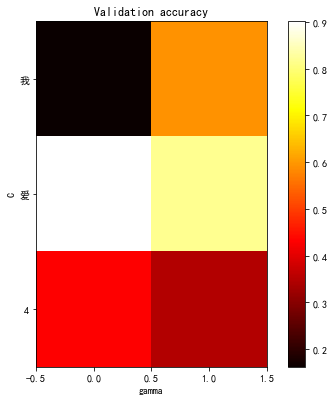

In [242]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False   # 步骤二（解决坐标轴负数的负号显示问题）

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
#设置标注前后左右的距离
scores = np.random.rand(3,2)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
        )
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
# plt.xticks(np.arange(3), [1,2,3], rotation=45)
plt.yticks(np.arange(3), ['我','爱',4])

plt.title('Validation accuracy')
plt.show()

In [243]:
import pickle as pkl
with open(r'C:\Users\chunhui\Desktop\南京大学\NLP组\TextCNN_Mindspore\THUCNews\checkpoint\vocab.pkl','rb') as f:
    vocab_dict = pkl.load(f)
id2word_dict = {value:key for key,value in vocab_dict.items()}

In [244]:
import random
def random_choose_one_visualize(id2word_dict,text,label,avg_attn_score,idx=None):
    if idx is None:
        idx = np.random.randint(len(text))
    text_one = text[idx].tolist()
    label_one = label[idx]
    ori_text_list = [id2word_dict[num] for num in text_one]
    ori_test = ''.join(ori_text_list)
    print('原文本:',ori_test)
    print('label:',label_one)
    attn_score = avg_attn_score[idx].tolist()
    plt.figure(figsize=(8, 6))
    plt.imshow(attn_score, interpolation='nearest', cmap=plt.cm.hot)
    plt.colorbar()
    plt.xticks(np.arange(len(text_one)), ori_text_list)
    plt.yticks(np.arange(len(text_one)), ori_text_list)

    plt.title('Validation accuracy')
    plt.show()

原文本: 假军官交友网站骗两女子10余万元<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
label: tensor(4)


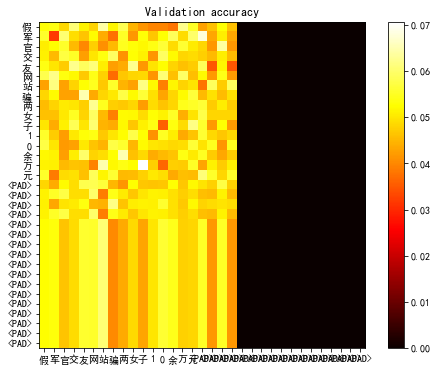

In [245]:
random_choose_one_visualize(id2word_dict,dev_text,dev_labels,avg_attn_probs)